# Heat Equation on General Domains using Galerkin Finite Element Method for the Spatial Discretization 

Solves the heat equation $\frac{\partial \, u(x,y,t)}{\partial t} = \bigtriangleup u + f$ on 2D general domains domains supplied with the homogeneous Dirichlet boundary condition $u = 0$ on $\Gamma$.

Careful: parts of this notebook may contain bugs. 

## Import Packages

In [1]:
import Gmsh: gmsh 
using GR 
using GRUtils
using LinearAlgebra
using SparseArrays
using DifferentialEquations
using Plots
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

Logging.ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(47) open, 0 bytes waiting))), Info, Logging.default_metafmt, true, 0, Dict{Any, Int64}())

## Geometry Definition 

In [2]:
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
#..define the model
model = gmsh.model
model.add("Transformer")
#..define mesh density near a point
lg = 0.7    #gap length in mm
#lg = 5    #gap length in mm
mur = 2000;  #relative permeability of the core
mu0 = 4*pi*10^(-7);
curr_dens_value = 3.1085;
k = 0.2227
cl = 5     #mesh size at bounday
c2 = lg/2  #mesh size at airgap
c3 = 2     #mesh size at component
#..define four points in the geometry
gmsh.model.geo.addPoint(50, 50, 0., cl, 1)
gmsh.model.geo.addPoint(-50, 50, 0., cl, 2)
gmsh.model.geo.addPoint(-50, -50,0., cl, 3)
gmsh.model.geo.addPoint(50, -50, 0., cl, 4)
#..upper half of core
gmsh.model.geo.addPoint(-27.25, lg/2, 0., c2, 5)
gmsh.model.geo.addPoint(-27.25, 27.6+lg/2, 0., c3, 6)
gmsh.model.geo.addPoint(27.25, 27.6+lg/2, 0., c3, 7)
gmsh.model.geo.addPoint(27.25, lg/2, 0., c2, 8)
gmsh.model.geo.addPoint(20.6, lg/2, 0., c2, 9)
gmsh.model.geo.addPoint(20.6, 20.2+lg/2, 0., c3, 10)
gmsh.model.geo.addPoint(7.422, 20.2+lg/2, 0., c3, 11)
gmsh.model.geo.addPoint(7.422, lg/2, 0., c2, 12)
gmsh.model.geo.addPoint(-7.422, lg/2, 0., c2, 13)
gmsh.model.geo.addPoint(-7.422, 20.2+lg/2, 0., c3, 14)
gmsh.model.geo.addPoint(-20.6, 20.2+lg/2, 0., c3, 15)
gmsh.model.geo.addPoint(-20.6, lg/2, 0., c2, 16)
#..lower half of core
gmsh.model.geo.addPoint(-27.25, -lg/2, 0., c2, 17)
gmsh.model.geo.addPoint(-27.25, -27.6-lg/2, 0., c3, 18)
gmsh.model.geo.addPoint(27.25, -27.6-lg/2, 0., c3, 19)
gmsh.model.geo.addPoint(27.25, -lg/2, 0., c2, 20)
gmsh.model.geo.addPoint(20.6, -lg/2, 0., c2, 21)
gmsh.model.geo.addPoint(20.6, -20.2-lg/2, 0., c3, 22)
gmsh.model.geo.addPoint(7.422, -20.2-lg/2, 0., c3, 23)
gmsh.model.geo.addPoint(7.422, -lg/2, 0., c2, 24)
gmsh.model.geo.addPoint(-7.422, -lg/2, 0., c2, 25)
gmsh.model.geo.addPoint(-7.422, -20.2-lg/2, 0., c3, 26)
gmsh.model.geo.addPoint(-20.6, -20.2-lg/2, 0., c3, 27)
gmsh.model.geo.addPoint(-20.6, -lg/2, 0., c2, 28)
#..define four edges in the geometry
gmsh.model.geo.addLine(1, 2, 101)
gmsh.model.geo.addLine(2, 3, 102)
gmsh.model.geo.addLine(3, 4, 103)
gmsh.model.geo.addLine(4, 1, 104)
#..upper half of core
gmsh.model.geo.addLine(5, 6, 105)
gmsh.model.geo.addLine(6, 7, 106)
gmsh.model.geo.addLine(7, 8, 107)
gmsh.model.geo.addLine(8, 9, 108)
gmsh.model.geo.addLine(9, 10, 109)
gmsh.model.geo.addLine(10, 11, 110)
gmsh.model.geo.addLine(11, 12, 111)
gmsh.model.geo.addLine(12, 13, 112)
gmsh.model.geo.addLine(13, 14, 113)
gmsh.model.geo.addLine(14, 15, 114)
gmsh.model.geo.addLine(15, 16, 115)
gmsh.model.geo.addLine(16, 5, 116)
#..lower half of core
gmsh.model.geo.addLine(18, 17, 117)
gmsh.model.geo.addLine(19, 18, 118)
gmsh.model.geo.addLine(20, 19, 119)
gmsh.model.geo.addLine(21, 20, 120)
gmsh.model.geo.addLine(22, 21, 121)
gmsh.model.geo.addLine(23, 22, 122)
gmsh.model.geo.addLine(24, 23, 123)
gmsh.model.geo.addLine(25, 24, 124)
gmsh.model.geo.addLine(26, 25, 125)
gmsh.model.geo.addLine(27, 26, 126)
gmsh.model.geo.addLine(28, 27, 127)
gmsh.model.geo.addLine(17, 28, 128)
# close off winding slots (right to left)
gmsh.model.geo.addLine(21, 9, 129)
gmsh.model.geo.addLine(12, 24, 130)
gmsh.model.geo.addLine(25, 13, 131)
gmsh.model.geo.addLine(16, 28, 132)
# link core area to outside
gmsh.model.geo.addLine(2, 6, 133)
gmsh.model.geo.addLine(19, 4, 134)
gmsh.model.geo.addLine(9, 21, 135)
gmsh.model.geo.addLine(6, 2, 136)
gmsh.model.geo.addLine(4, 19, 137)
gmsh.model.geo.addLine(28,16, 138)
# redefine air gap lines for middle gap
gmsh.model.geo.addLine(24, 12, 139)
gmsh.model.geo.addLine(13, 25, 140)
#..define outer boundary
gmsh.model.geo.addCurveLoop([101, 133, 106, 107, 108, 135, 120, 119, 134, 104], 201) # air 1
gmsh.model.geo.addCurveLoop([102, 103, 137, 118, 117, 128, 138, 116, 105, 136], 202) # air 2
gmsh.model.geo.addCurveLoop([105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116], 203) # upper core
gmsh.model.geo.addCurveLoop([117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128], 204) # lower core
gmsh.model.geo.addCurveLoop([109, 110, 111, 130, 123, 122 , 121, 129], 205) # right winding gap
gmsh.model.geo.addCurveLoop([113, 114, 115, 131, 125, 126 ,127, 132], 206) # left winding gap
gmsh.model.geo.addCurveLoop([112, 140, 124, 139], 207) # middle air gap
#..define planar surface
gmsh.model.geo.addPlaneSurface([201], 301)
gmsh.model.geo.addPlaneSurface([202], 302)
gmsh.model.geo.addPlaneSurface([203], 303)
gmsh.model.geo.addPlaneSurface([204], 304)
gmsh.model.geo.addPlaneSurface([205], 305)
gmsh.model.geo.addPlaneSurface([206], 306)
gmsh.model.geo.addPlaneSurface([207], 307)
#..define physics
gmsh.model.addPhysicalGroup(2,[301; 302; 307],401)
gmsh.model.addPhysicalGroup(2,[303],402)
gmsh.model.addPhysicalGroup(2,[304],403)
gmsh.model.addPhysicalGroup(2,[305],404)
gmsh.model.addPhysicalGroup(2,[306],405)
#..generate the mesh in 2D
gmsh.model.geo.synchronize()
model.mesh.generate(2)
#..save the mesh to file for future reference
#gmsh.write("transformer.msh")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 101 (Line)
Info    : [ 10%] Meshing curve 102 (Line)
Info    : [ 10%] Meshing curve 103 (Line)
Info    : [ 10%] Meshing curve 104 (Line)
Info    : [ 10%] Meshing curve 105 (Line)
Info    : [ 20%] Meshing curve 106 (Line)
Info    : [ 20%] Meshing curve 107 (Line)
Info    : [ 20%] Meshing curve 108 (Line)
Info    : [ 20%] Meshing curve 109 (Line)
Info    : [ 30%] Meshing curve 110 (Line)
Info    : [ 30%] Meshing curve 111 (Line)
Info    : [ 30%] Meshing curve 112 (Line)
Info    : [ 30%] Meshing curve 113 (Line)
Info    : [ 40%] Meshing curve 114 (Line)
Info    : [ 40%] Meshing curve 115 (Line)
Info    : [ 40%] Meshing curve 116 (Line)
Info    : [ 40%] Meshing curve 117 (Line)
Info    : [ 50%] Meshing curve 118 (Line)
Info    : [ 50%] Meshing curve 119 (Line)
Info    : [ 50%] Meshing curve 120 (Line)
Info    : [ 50%] Meshing curve 121 (Line)
Info    : [ 60%] Meshing curve 122 (Line)
Info    : [ 60%] Meshing curve 123 (Line)
Info    : 

In [6]:
#..2/11 Get and sort the mesh nodes
#..Observe that although the mesh is two-dimensional,
#..the z-coordinate that is equal to zero is stored as well.
#..Observe that the coordinates are stored contiguously for computational
#..efficiency
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

#..3/11 Plotting the mesh
z = ones(length(xnode))
GR.trisurf(xnode,ynode,z)

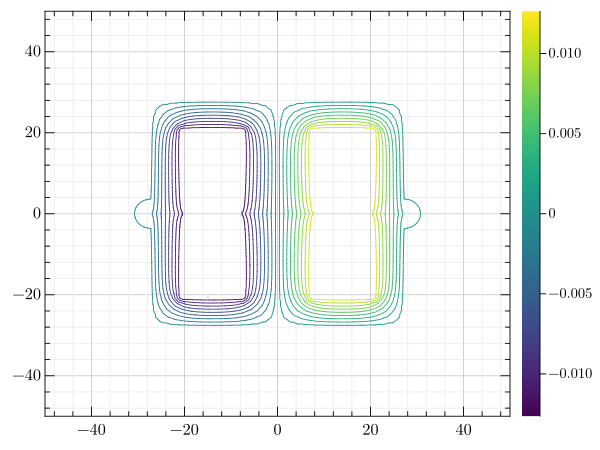

In [7]:
#..4/12 Get the mesh elements
#..observe that we get all the two-dimensional triangular elements from the mesh
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..5/12 Create groups of elements for the subdomains
#..for loop that creates a vector describing which physical group an element belongs to
ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 401)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 402)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 403)
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 404)
ngroup5 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 405)
e_group = zeros(1,nelements)
for element_id in 1:nelements
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]
  G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1])+sum(node3_id.== ngroup1[1]) #Air
  G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1])+sum(node3_id.== ngroup2[1]) #upper core
  G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1])+sum(node3_id.== ngroup3[1]) #lower core
  G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1])+sum(node3_id.== ngroup4[1]) #winding right
  G5 = sum(node1_id.== ngroup5[1])+sum(node2_id.== ngroup5[1])+sum(node3_id.== ngroup5[1]) #winding left
  if G1 == 3
    e_group[element_id] = 1;
  elseif G2 == 3 || G3 == 3
    e_group[element_id] = 2;
  elseif G4 == 3
    e_group[element_id] = 4;
  elseif G5 == 3
    e_group[element_id] = 5;
  end
  if (false)
    println("on element ", element_id, " e_group[element_id] = ", e_group[element_id])
  end
end

#..6/12 Define the source function and the reluctivity function and
#..define the source function and reluctivity value for each element in the mesh using map.
#..Observe that, unlike before, both the source function and the reluctivity function are defined
#..as constant values per element (instead of constant per node).
#..The source function defines the current density value in the left and right side of the winding.
sourcefunction(group_id) = curr_dens_value*(group_id==4)-curr_dens_value*(group_id==5)
sourceperelement = map(sourcefunction, e_group)
#..The reluctivity function defines the reluctivity value over the whole domain
#..The reluctivity is set equal to nu0 = 1/mu0 in the coil and air subdomains
#..The reluctivity is set equal to nu=1/mu=1/(mu0*muR) in the ferromagnetic core subdomains
reluctivityfunction(group_id) = (1/mu0)*((group_id==1)+(group_id==4)+(group_id==5))+(1/(mu0*mur))*((group_id==2)+mur*(group_id==3))
reluctivityperelement = map(reluctivityfunction, e_group)

#..7/12 initialize global matrix A and global vector f
#..observe that for simplicity we use dense matrix here
A = zeros(nnodes,nnodes)
M = zeros(nnodes,nnodes)
f = zeros(nnodes,1)

#..8/12 Perform a loop over the elements
for element_id in 1:nelements

  #....retrieve global numbering of the local nodes of the current element
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]

  #....retrieve the x and y coordinates of the local nodes of the current element
  xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
  ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

  #....compute surface area of the current element
  x12 = xnode2 - xnode1; x13 = xnode3-xnode1;
  y12 = ynode2 - ynode1; y13 = ynode3-ynode1;
  area_id = x12*y13 - x13*y12; area_id = abs(area_id)/2

  #....if desired, print global number numbers and element area to screen
  if (false)
    println("on element ", element_id, " node-1 has global number ", node1_id)
    println("on element ", element_id, " node-2 has global number ", node2_id)
    println("on element ", element_id, " node-3 has global number ", node3_id)
    println("on element ", element_id, " area = ", area_id)
    println(" ")
  end

  #....compute local vector contribution floc of the current element
  floc = area_id/3*sourceperelement[element_id]*[1; 1; 1]

  #....compute local matrix contribution Aloc of the current element
  Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
  Emat[3,:] .= 0;
  Aloc = area_id*reluctivityperelement[element_id]*(transpose(Emat)*Emat);
  Mloc = area_id/3*[1 0 0; 0 1 0; 0 0 1]; 
    
  #....perform loop over nodes of the current element
  #....and add local contribution Aloc to global matrix entity A
  for i = 1:3
    I = element_connectivity[1][3*(element_id-1)+i]
    f[I] += floc[i]
    for j = 1:3
      J = element_connectivity[1][3*(element_id-1)+j]
      A[I,J] += Aloc[i,j]
      M[I,J] += Mloc[i,j]
    end
  end

end

#..9/12 Handle the boundary conditions
#..retrieve boundary nodes by loop over corner point and boundary edges
node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,101)
node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,102)
node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,103)
node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,104)
bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
A[bnd_node_ids,:] .= 0;
A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
f[bnd_node_ids] .= 0;

#..10/12 Make A sparse and M diagonal 
A = sparse(A)
M = Diagonal(M)

#..11/12 Compute the numerical solution
u = A\f

#..12/12 Plot the numerical solution and perform post-processing
Bav = (maximum(u)-minimum(u))/(2*7.422*0.001) # estimate the core flux desnity
if (false)
  println("The estimated magnetic flux density in the core is equal to ", Bav, " T")
end
p1 = GR.tricont(xnode,ynode,u)

In [5]:
#..11/11 Finalize GMSH
gmsh.finalize()

In [6]:
#..solves the z-component of the magnetic vector potential for a transformer
#..the diffusion coefficient for the magnetic vector potential is the reluctivity
#..the reluctivity nu is defined as the reciprocal of the permeability mu, i.e., nu = 1/mu
#..the reluctivity if vacuum (air) is denoted as nu0 and is given by nu0 = 1/mu0 where mu0 = 4*pi*10^(-7)
#..the relative reluctivity is denoted as nuR and given by nuR = 1/muR

#..1/12 Define geometry and mesh. Save mesh to file.
gmsh.initialize()

#..read the mesh to file for future reference
gmsh.open("transformer.msh")

#..2/12 Get and sort the mesh nodes
#..Observe that although the mesh is two-dimensional,
#..the z-coordinate that is equal to zero is stored as well.
#..Observe that the coordinates are stored contiguously for computational
#..efficiency
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

#..3/12 Plotting the mesh
#..for later: print mesh as VTK file and view using ParaView
#..(as documented under VTK.jl and as for instance GridApp.jl does)
z = ones(length(xnode))
#GR.trisurf(xnode,ynode,z)

#..4/12 Get the mesh elements
#..observe that we get all the two-dimensional triangular elements from the mesh
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..5/12 Create groups of elements for the subdomains
#..for loop that creates a vector describing which physical group an element belongs to
ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 401)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 402)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 403)
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 404)
ngroup5 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 405)
e_group = zeros(1,nelements)
for element_id in 1:nelements
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]
  G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1])+sum(node3_id.== ngroup1[1]) #Air
  G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1])+sum(node3_id.== ngroup2[1]) #upper core
  G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1])+sum(node3_id.== ngroup3[1]) #lower core
  G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1])+sum(node3_id.== ngroup4[1]) #winding right
  G5 = sum(node1_id.== ngroup5[1])+sum(node2_id.== ngroup5[1])+sum(node3_id.== ngroup5[1]) #winding left
  if G1 == 3
    e_group[element_id] = 1;
  elseif G2 == 3 || G3 == 3
    e_group[element_id] = 2;
  elseif G4 == 3
    e_group[element_id] = 4;
  elseif G5 == 3
    e_group[element_id] = 5;
  end
  if (false)
    println("on element ", element_id, " e_group[element_id] = ", e_group[element_id])
  end
end

#..6/12 Define the source function and the reluctivity function and
#..define the source function and reluctivity value for each element in the mesh using map.
#..Observe that, unlike before, both the source function and the reluctivity function are defined
#..as constant values per element (instead of constant per node).
#..The source function defines the current density value in the left and right side of the winding.
sourcefunction(group_id) = curr_dens_value*(group_id==4)-curr_dens_value*(group_id==5)
sourceperelement = map(sourcefunction, e_group)
#..The reluctivity function defines the reluctivity value over the whole domain
#..The reluctivity is set equal to nu0 = 1/mu0 in the coil and air subdomains
#..The reluctivity is set equal to nu=1/mu=1/(mu0*muR) in the ferromagnetic core subdomains
reluctivityfunction(group_id) = (1/mu0)*((group_id==1)+(group_id==4)+(group_id==5))+(1/(mu0*mur))*((group_id==2)+mur*(group_id==3))
reluctivityperelement = map(reluctivityfunction, e_group)

#..7/12 initialize global matrix A and global vector f
#..observe that for simplicity we use dense matrix here
A = zeros(nnodes,nnodes)
M = zeros(nnodes,nnodes)
f = zeros(nnodes,1)

#..8/12 Perform a loop over the elements
for element_id in 1:nelements

  #....retrieve global numbering of the local nodes of the current element
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]

  #....retrieve the x and y coordinates of the local nodes of the current element
  xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
  ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

  #....compute surface area of the current element
  x12 = xnode2 - xnode1; x13 = xnode3-xnode1;
  y12 = ynode2 - ynode1; y13 = ynode3-ynode1;
  area_id = x12*y13 - x13*y12; area_id = abs(area_id)/2

  #....if desired, print global number numbers and element area to screen
  if (false)
    println("on element ", element_id, " node-1 has global number ", node1_id)
    println("on element ", element_id, " node-2 has global number ", node2_id)
    println("on element ", element_id, " node-3 has global number ", node3_id)
    println("on element ", element_id, " area = ", area_id)
    println(" ")
  end

  #....compute local vector contribution floc of the current element
  floc = area_id/3*sourceperelement[element_id]*[1; 1; 1]

  #....compute local matrix contribution Aloc of the current element
  Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
  Emat[3,:] .= 0;
  Aloc = area_id*reluctivityperelement[element_id]*(transpose(Emat)*Emat);
  Mloc = area_id/3*[1 0 0; 0 1 0; 0 0 1]; 

  #....perform loop over nodes of the current element
  #....and add local contribution Aloc to global matrix entity A
  for i = 1:3
    I = element_connectivity[1][3*(element_id-1)+i]
    f[I] += floc[i]
    for j = 1:3
      J = element_connectivity[1][3*(element_id-1)+j]
      A[I,J] += Aloc[i,j]
      M[I,J] += Mloc[i,j]; 
    end
  end

end

#..9/12 Handle the boundary conditions
#..retrieve boundary nodes by loop over corner point and boundary edges
node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,101)
node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,102)
node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,103)
node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,104)
bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
A[bnd_node_ids,:] .= 0;
A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
f[bnd_node_ids] .= 0;

#..Convert A and M to sparse format 
A = sparse(A)
M = Diagonal(M)

#..10/12 Compute the numerical solution
u = A\f

#..11/12 Plot the numerical solution and perform post-processing
Bav = (maximum(u)-minimum(u))/(2*7.422*0.001) # estimate the core flux desnity
if (false)
  println("The estimated magnetic flux density in the core is equal to ", Bav, " T")
end
# tricont(xnode,ynode,u)
GR.tricont(xnode,ynode,u)

#..12/12 Finalize GMSH
gmsh.finalize()

LoadError: BoundsError: attempt to access 0-element Vector{Vector{UInt64}} at index [1]

GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
invalid number of points


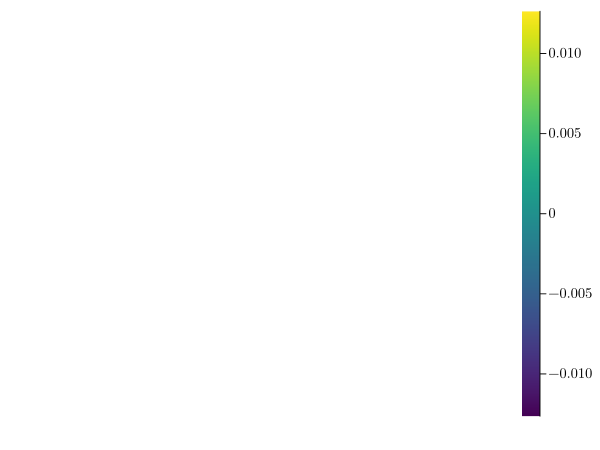

In [10]:
GR.tricont(xnode,ynode,u)

## Section 2:/ Extend to Time-Domain 

### Defining the Problem

In [8]:
# set time interval and time step 
t0 = 0.0
tf = 4*0.02
Nt = 4*100 
dt = (tf - t0)/Nt 
# Vector t holds 0 and is Nt+1 long 
tvec = Vector(t0:dt:Nt*dt)

#..define the right-hand side of the ordinary differential equation of the equation of motion 
function scalarDiffusionEquation!(du,u,p,t)
    du[:] = M \ (sin(2*π*50*t)*f - A*u)
end

#..set initial position and velocity
u0 = fill(0.,nnodes)
                                    
#..set time begin and end forward
tspan = (t0,tf)

#..define ODE problem to be solved  
prob_scalarDiffusion = ODEProblem(scalarDiffusionEquation!, u0, tspan)

#..solve ODE problem 
sol = DifferentialEquations.solve(prob_scalarDiffusion);

#..interpolate solution in desired time samples
U = zeros(nnodes,length(tvec))
for k=1:length(tvec) 
  U[:,k] = sol(tvec[k])
end

In [9]:
GR.subplot(2,2,1)
p1 = GR.tricont(xnode,ynode,U[:,325])
GR.subplot(2,2,2)
p1 = GR.tricont(xnode,ynode,U[:,350])
GR.subplot(2,2,3)
p1 = GR.tricont(xnode,ynode,U[:,375])
GR.subplot(2,2,4)
p1 = GR.tricont(xnode,ynode,U[:,400])

In [92]:
anim = @animate for i in 1:Nt
    GR.tricont(xnode,ynode,U[:,i])
end
gif(anim, "my-animation.gif", fps = 1)

LoadError: No current plot/subplot

In [95]:
? @animate 

Collect one frame per for-block iteration and return an `Animation` object.

Example:

```
p = plot(1)
anim = @animate for x=0:0.1:5
    push!(p, 1, sin(x))
end
gif(anim)
```

This macro supports additional parameters, that may be added after the main loop body.

  * Add `every n` with positive Integer n, to take only one frame every nth iteration.
  * Add `when <cond>` where `<cond>` is an Expression resulting in a Boolean, to take a    frame only when `<cond>` returns `true`. Is incompatible with `every`.


In [99]:
@macroexpand @animate

LoadError: MethodError: no method matching var"@animate"(::LineNumberNode, ::Module)
[0mClosest candidates are:
[0m  var"@animate"(::LineNumberNode, ::Module, [91m::Expr[39m, [91m::Any...[39m) at ~/.julia/packages/Plots/tDI0A/src/animation.jl:316